In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import missingno as msno
import geopandas as gpd
from shapely.geometry import Point

In [53]:
# Configuración de estilo para las gráficas
sns.set(style="whitegrid")
# plt.rcParams['figure.figsize'] = (10, 6)

In [49]:
# Cargar datos
ruta_datos_query = r"C:\Users\DELL\Documents\basesdedatosProyecto\Datos\BioTIMEQuery_24_06_2021.csv"
samples = pd.read_csv(ruta_datos_query, dtype={'PLOT': str, 'GENUS': str, 'SPECIES': str, 'GENUS_SPECIES': str});

In [54]:
ruta_Datos_md = r"C:\Users\DELL\Documents\basesdedatosProyecto\Datos\BioTIMEMetadata_24_06_2021.csv"
studies = pd.read_csv(ruta_Datos_md, delimiter=',', encoding='ISO-8859-2', dtype={'REALM': str, 'CLIMATE': str, 'HABITAT': str, 'BIOME_MAP': str, 'DATA_SOURCE': str, 'DATE_STUDY_ADDED': str, 'ABUNDANCE_TYPE': str, 'BIOMASS_TYPE': str})

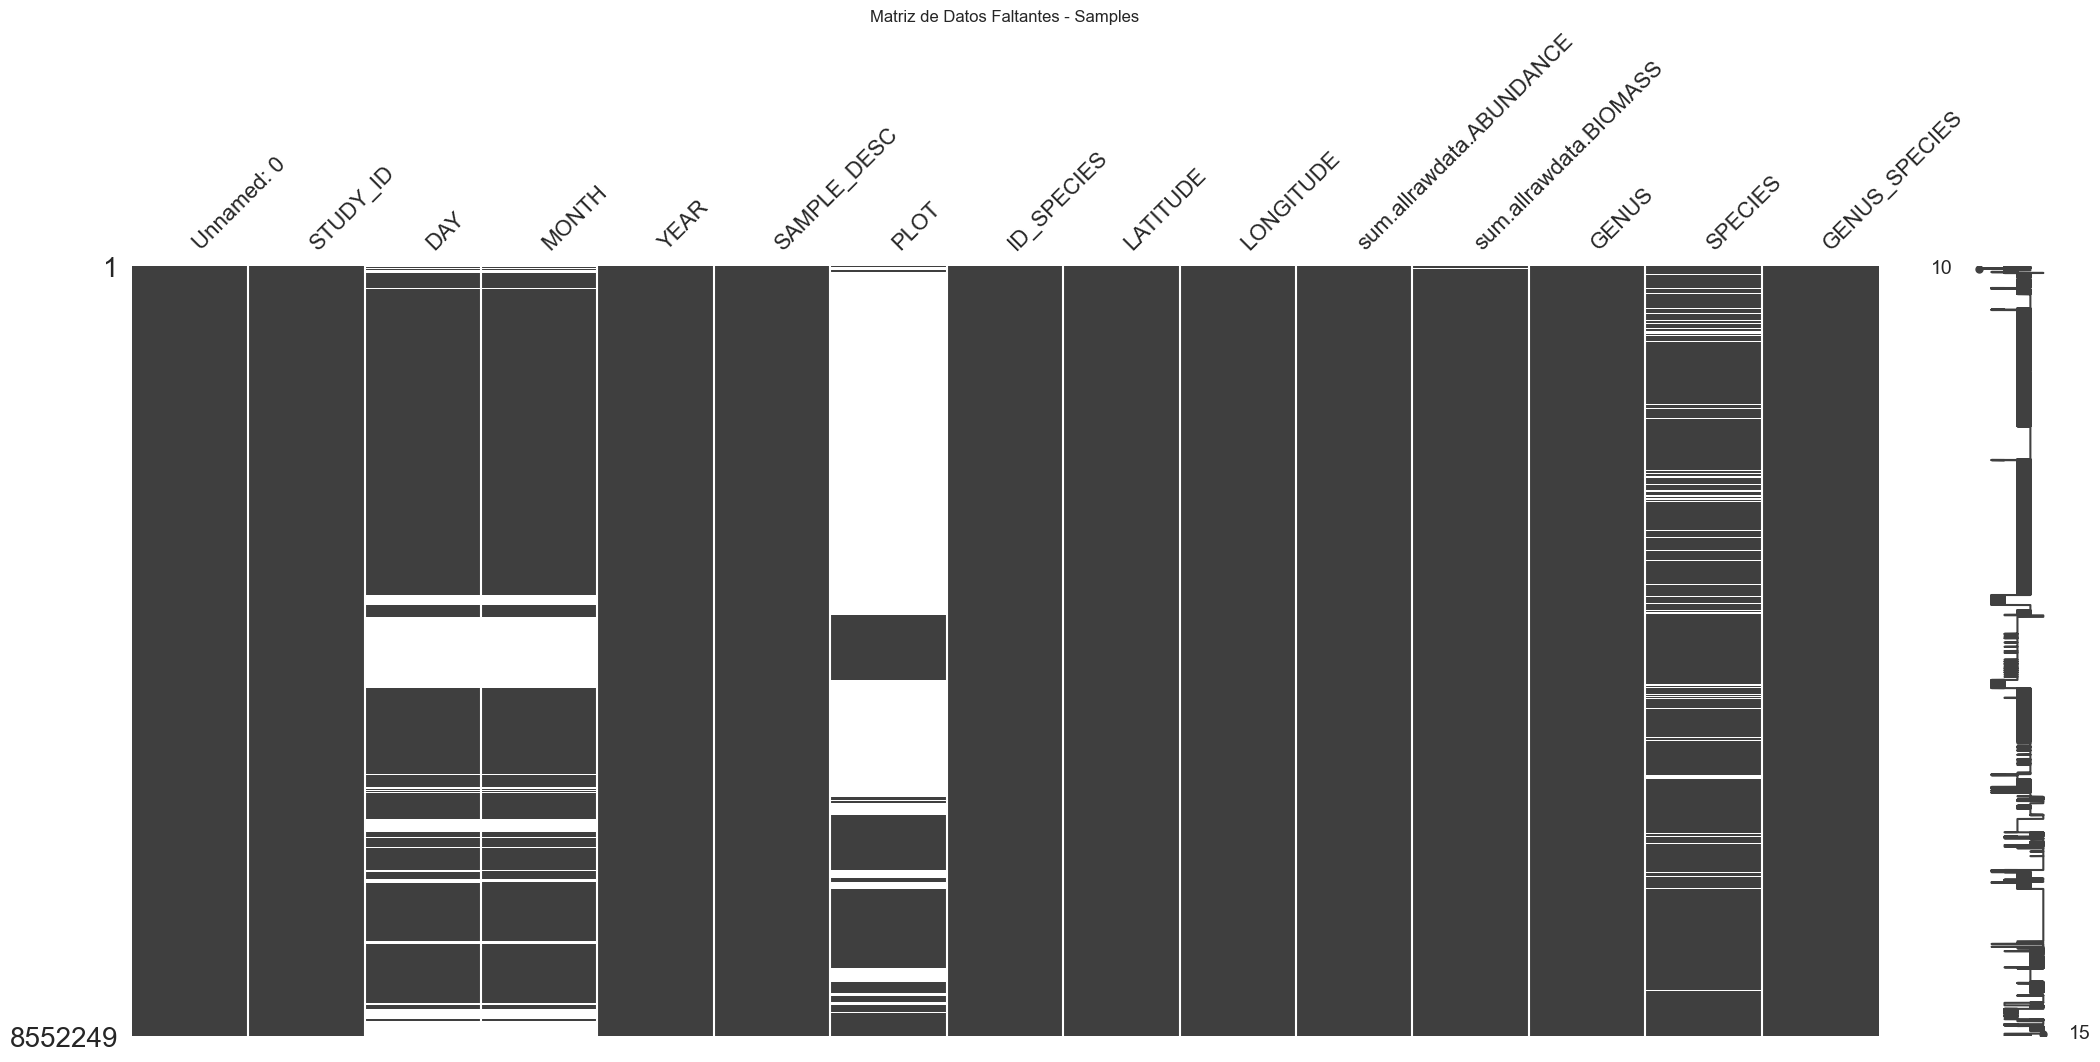

In [50]:
msno.matrix(samples)
plt.title("Matriz de Datos Faltantes - Samples")
plt.show()  

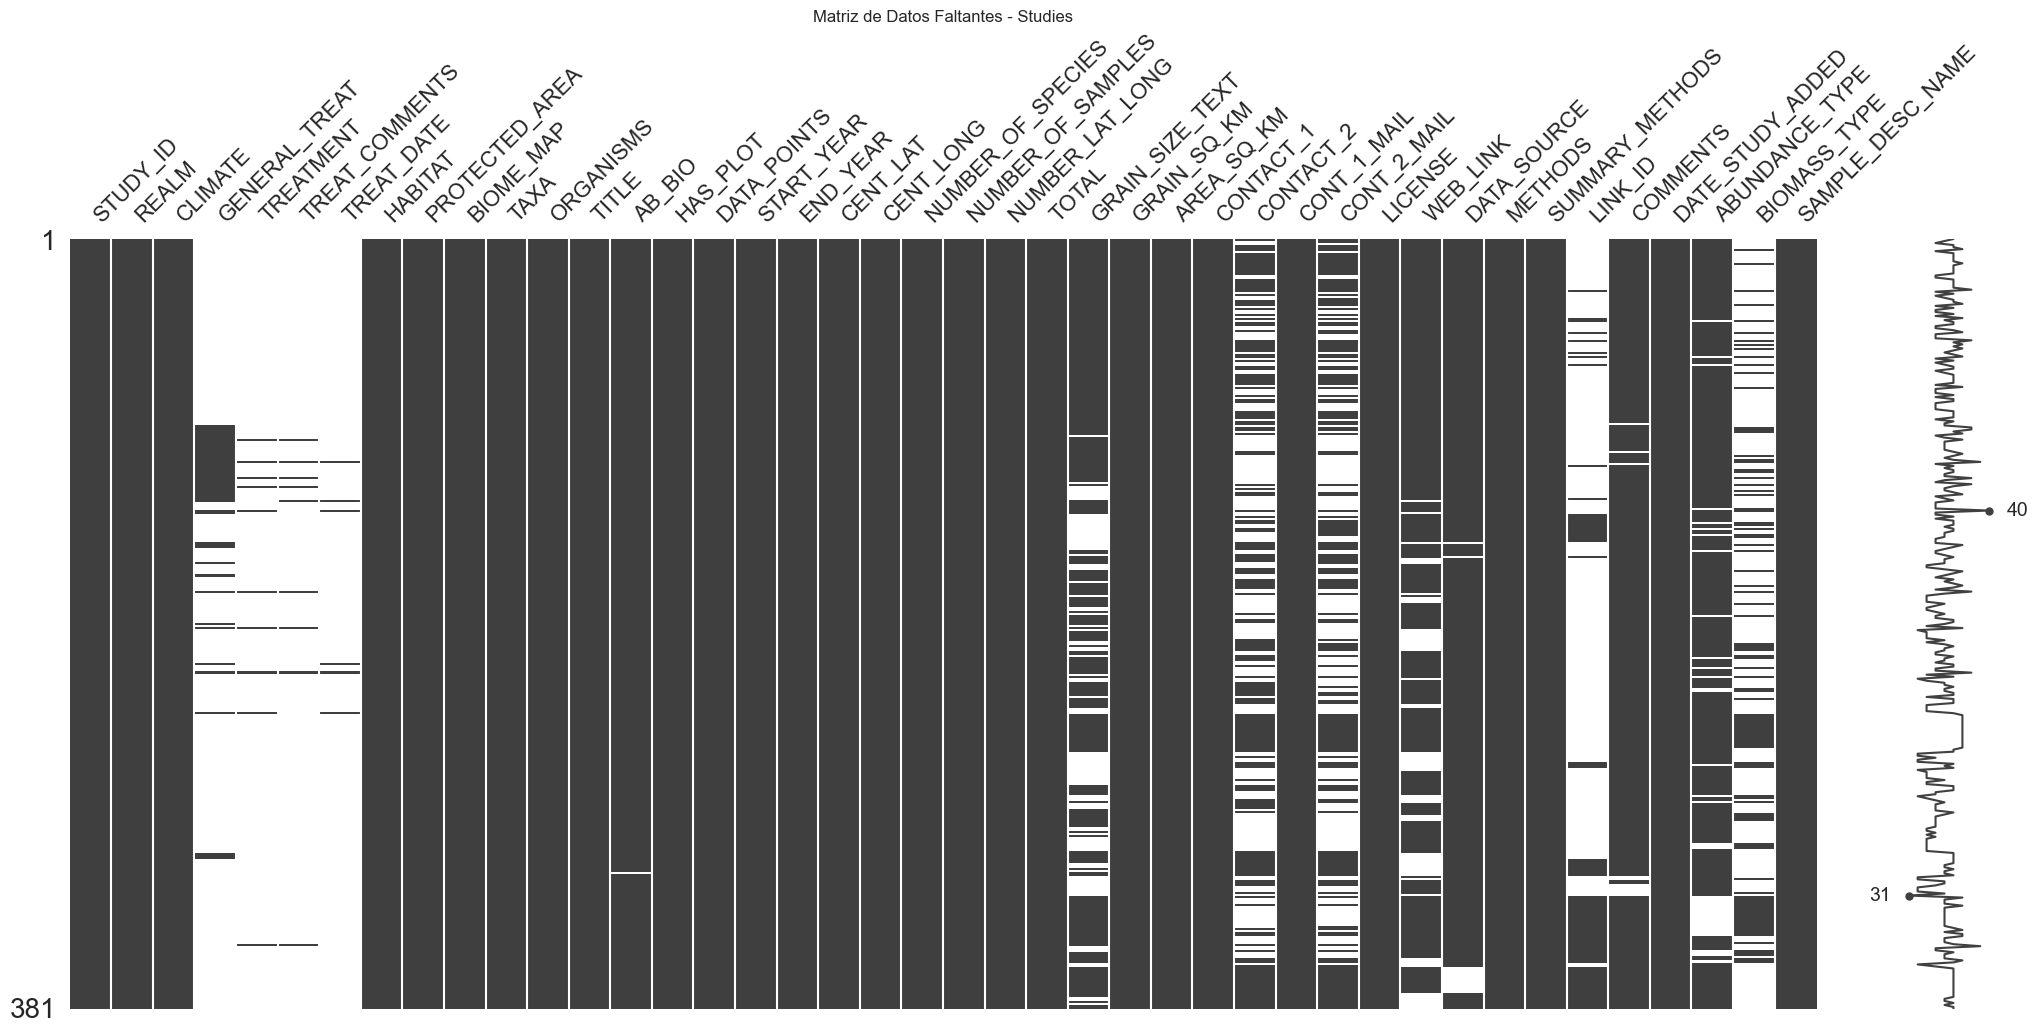

In [44]:
msno.matrix(studies)
plt.title("Matriz de Datos Faltantes - Studies")
plt.show()

In [95]:
studies_numeric_cols = [
    "DATA_POINTS",
    "START_YEAR",
    "END_YEAR",
    "CENT_LAT",
    "CENT_LONG",
    "NUMBER_OF_SPECIES",
    "NUMBER_OF_SAMPLES",
    "TOTAL",
    "GRAIN_SQ_KM",
    "AREA_SQ_KM",
    "STUDY_ID"]

samples_numeric_cols = [
    "YEAR",
    "LATITUDE",
    "LONGITUDE",
    "sum.allrawdata.ABUNDANCE",
    "sum.allrawdata.BIOMASS",
    "STUDY_ID"
]

In [96]:
df_samples_numeric = samples[samples_numeric_cols]
df_studies_numeric = studies[studies_numeric_cols]


In [97]:
# Función para eliminar outliers usando el rango intercuartílico (IQR)
def remove_outliers(df, columns):
    for col in columns:
        if df[col].dtype in ['float64', 'int64']:  # Solo aplicar a columnas numéricas
            
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    
    return df

In [98]:
# Filtrar outliers en ambos datasets
samples_cleaned = remove_outliers(df_samples_numeric, samples_numeric_cols)
studies_cleaned = remove_outliers(df_studies_numeric, studies_numeric_cols)

In [81]:
# Mostrar la cantidad de filas antes y después del filtrado
print(f"Filas en 'samples' antes del filtrado: {len(samples)}, después: {len(samples_cleaned)}")
print(f"Filas en 'studies' antes del filtrado: {len(studies)}, después: {len(studies_cleaned)}")

Filas en 'samples' antes del filtrado: 8552249, después: 3455692
Filas en 'studies' antes del filtrado: 381, después: 117


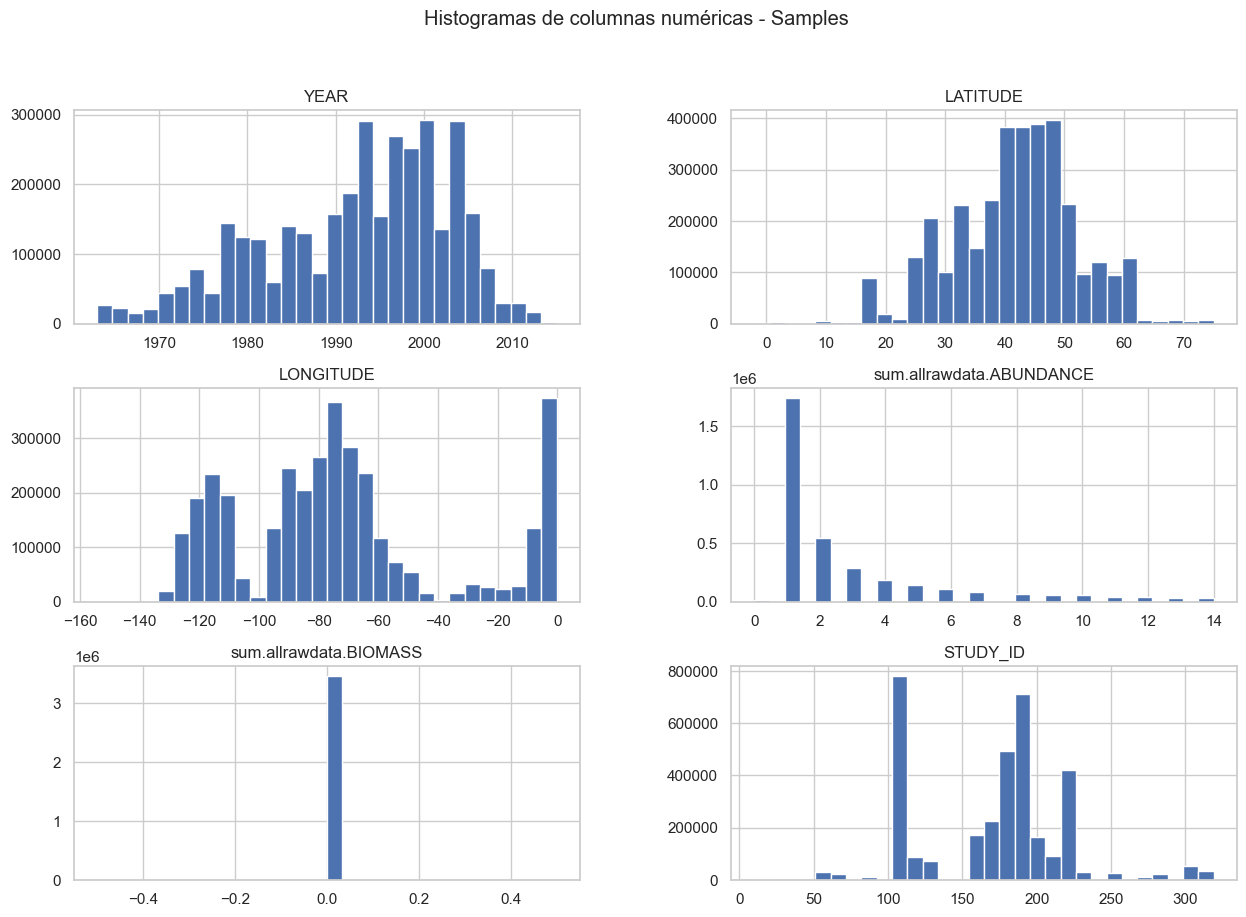

In [82]:

samples_cleaned.hist(bins=30, figsize=(15, 10))
plt.suptitle("Histogramas de columnas numéricas - Samples")
plt.show()

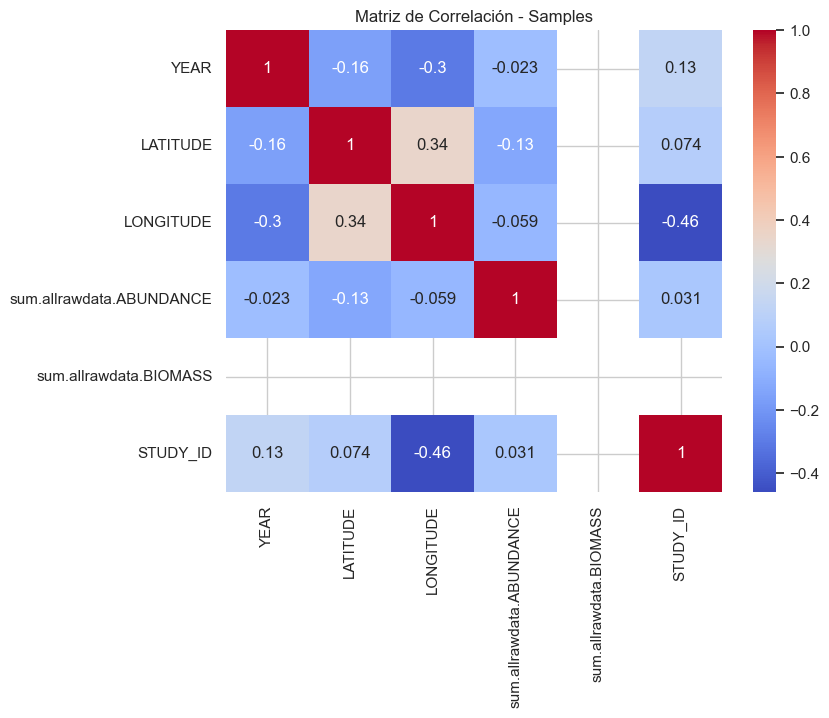

In [83]:
# Matriz de correlación para variables numéricas
corr = samples_cleaned.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Matriz de Correlación - Samples")
plt.show()

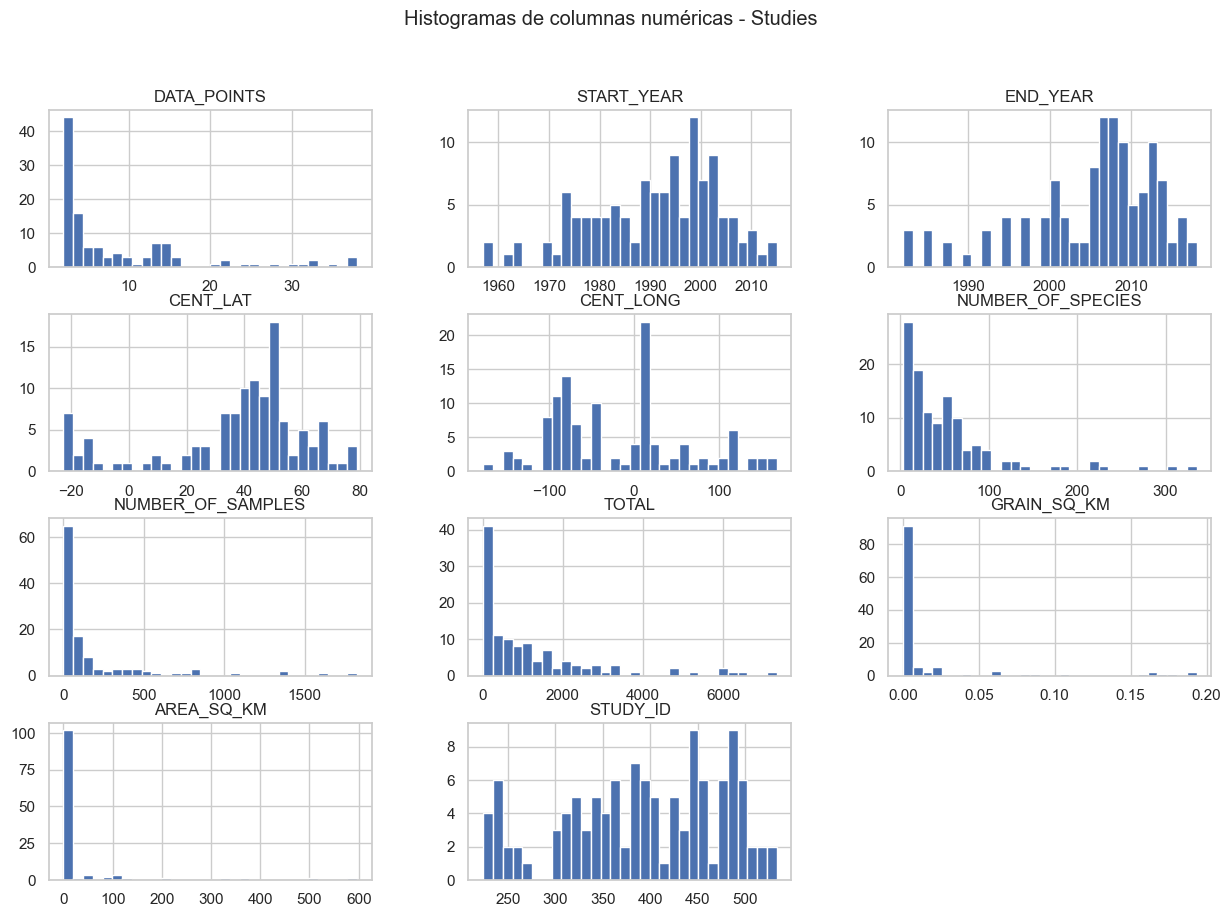

In [85]:
# Matriz de correlación para variables numéricas
studies_cleaned[studies_numeric_cols].hist(bins=30, figsize=(15, 10))
plt.suptitle("Histogramas de columnas numéricas - Studies")
plt.show()

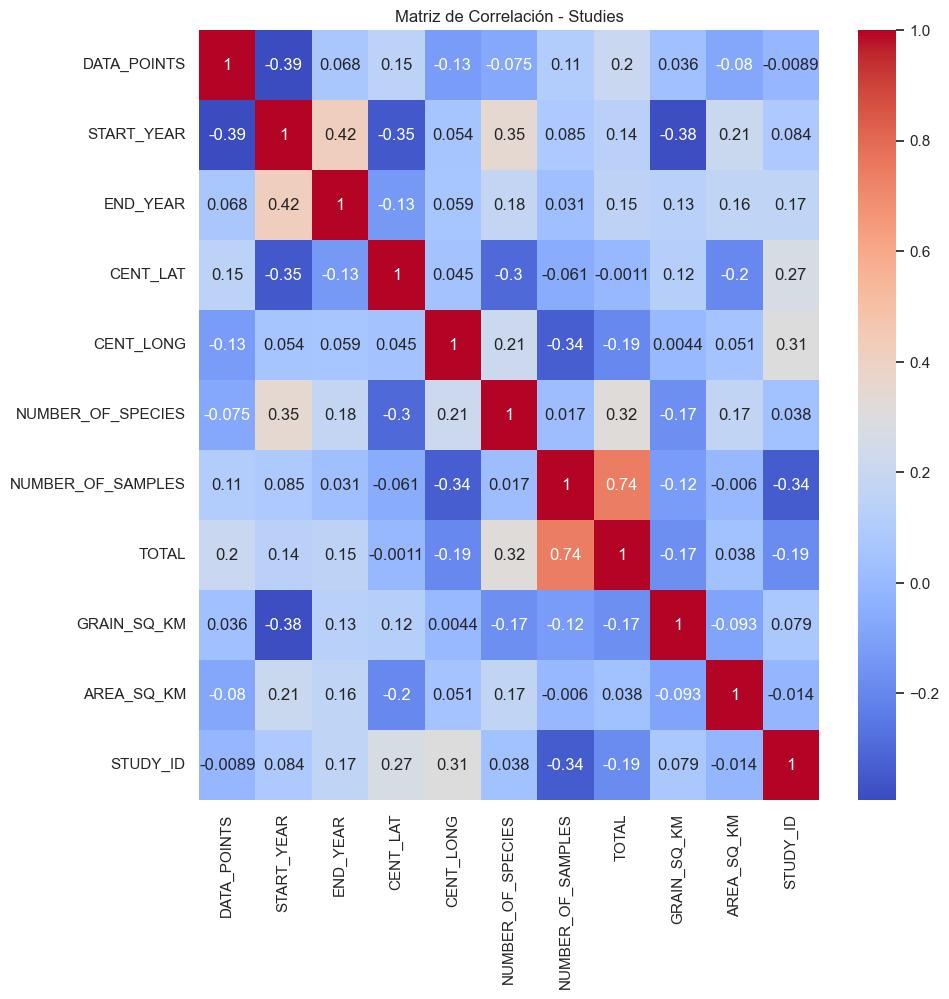

In [102]:
# Matriz de correlación para variables numéricas
corr = studies_cleaned[studies_numeric_cols].corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Matriz de Correlación - Studies")
plt.show()

In [87]:
shapefile_path = "./world/ne_10m_admin_0_countries.shp"
world = gpd.read_file(shapefile_path)

In [88]:
geometry_samples = [Point(xy) for xy in zip(samples_cleaned['LONGITUDE'], samples_cleaned['LATITUDE'])]
gdf_samples = gpd.GeoDataFrame(samples_cleaned, geometry=geometry_samples)
gdf_samples.crs = "EPSG:4326"  # Sistema de coordenadas geográficas

In [89]:
samples_with_country = gpd.sjoin(gdf_samples, world, how="left", predicate="within")

In [90]:
samples_with_country[['LONGITUDE', 'LATITUDE', 'sum.allrawdata.ABUNDANCE', 'NAME','STUDY_ID']].head(5)

,LONGITUDE,LATITUDE,sum.allrawdata.ABUNDANCE,NAME,STUDY_ID
0,-95.12,47.4,1.0,United States of America,10
1,-95.12,47.4,3.0,United States of America,10
2,-95.12,47.4,1.0,United States of America,10
3,-95.12,47.4,12.0,United States of America,10
4,-95.12,47.4,1.0,United States of America,10


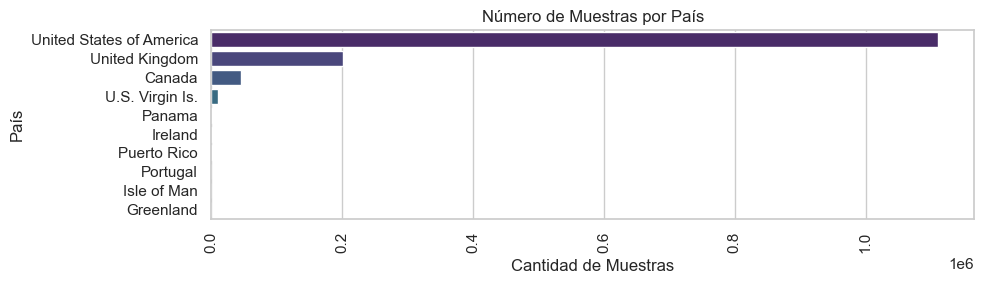

In [91]:
samples_by_country = samples_with_country.groupby('NAME').size().reset_index(name='counts')
samples_by_country.sort_values('counts', ascending=False, inplace=True)
# Gráfica: Número de muestras por país
plt.figure(figsize=(10, 3))
sns.barplot(data=samples_by_country[:10], x='counts', y='NAME', palette="viridis", hue='NAME')
plt.xticks(rotation=90)
plt.title("Número de Muestras por País")
plt.xlabel("Cantidad de Muestras")
plt.ylabel("País")
plt.tight_layout()
plt.show()

In [92]:
samples_usa = samples_with_country.loc[samples_with_country["NAME"] == "United States of America"]
samples_usa = samples_usa[samples_numeric_cols]
print (samples_usa.head(5))

   YEAR  LATITUDE  LONGITUDE  sum.allrawdata.ABUNDANCE  \
0  1984      47.4     -95.12                       1.0   
1  1984      47.4     -95.12                       3.0   
2  1984      47.4     -95.12                       1.0   
3  1984      47.4     -95.12                      12.0   
4  1984      47.4     -95.12                       1.0   

   sum.allrawdata.BIOMASS  STUDY_ID  
0                     0.0        10  
1                     0.0        10  
2                     0.0        10  
3                     0.0        10  
4                     0.0        10  


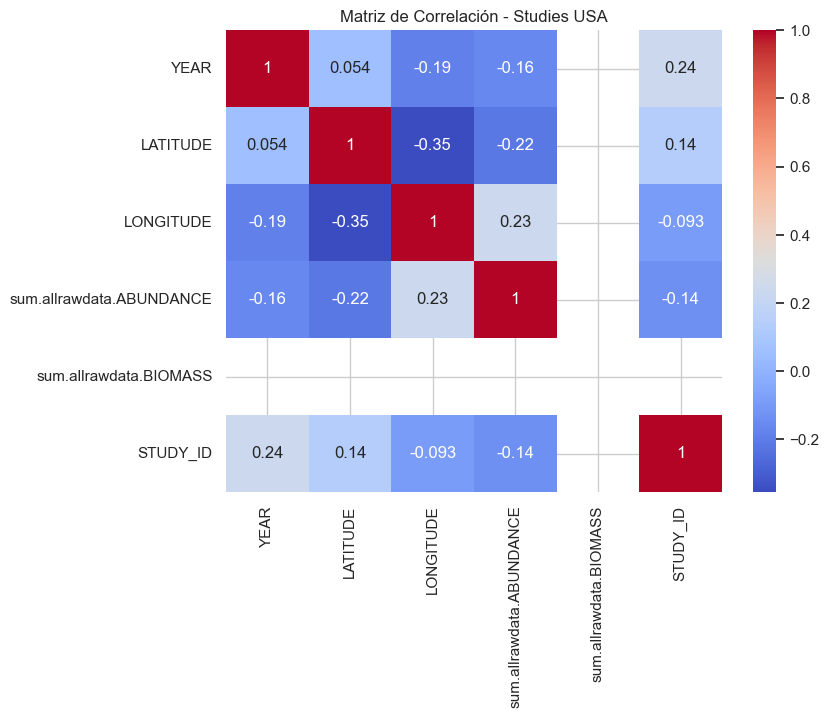

In [93]:
# Matriz de correlación para variables numéricas
corr_studies = samples_usa.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_studies, annot=True, cmap="coolwarm")
plt.title("Matriz de Correlación - Studies USA")
plt.show()

In [99]:
df_merged = pd.merge(samples_usa, studies_cleaned, on="STUDY_ID", how="inner")
print(df_merged.head(5))


   YEAR  LATITUDE  LONGITUDE  sum.allrawdata.ABUNDANCE  \
0  1995      45.4      -93.2                       4.0   
1  1995      45.4      -93.2                       2.0   
2  1995      45.4      -93.2                       2.0   
3  1995      45.4      -93.2                       2.0   
4  1995      45.4      -93.2                       7.0   

   sum.allrawdata.BIOMASS  STUDY_ID  DATA_POINTS  START_YEAR  END_YEAR  \
0                     0.0       224            3        1995      2005   
1                     0.0       224            3        1995      2005   
2                     0.0       224            3        1995      2005   
3                     0.0       224            3        1995      2005   
4                     0.0       224            3        1995      2005   

   CENT_LAT  CENT_LONG  NUMBER_OF_SPECIES  NUMBER_OF_SAMPLES  TOTAL  \
0      45.4      -93.2                 50               1582   5973   
1      45.4      -93.2                 50               1582   5

In [109]:
df_merged["DURATION"] = df_merged["END_YEAR"] - df_merged["START_YEAR"]
print(df_merged.head(5))

   YEAR  LATITUDE  LONGITUDE  sum.allrawdata.ABUNDANCE  \
0  1995      45.4      -93.2                       4.0   
1  1995      45.4      -93.2                       2.0   
2  1995      45.4      -93.2                       2.0   
3  1995      45.4      -93.2                       2.0   
4  1995      45.4      -93.2                       7.0   

   sum.allrawdata.BIOMASS  STUDY_ID  DATA_POINTS  START_YEAR  END_YEAR  \
0                     0.0       224            3        1995      2005   
1                     0.0       224            3        1995      2005   
2                     0.0       224            3        1995      2005   
3                     0.0       224            3        1995      2005   
4                     0.0       224            3        1995      2005   

   CENT_LAT  CENT_LONG  NUMBER_OF_SPECIES  NUMBER_OF_SAMPLES  TOTAL  \
0      45.4      -93.2                 50               1582   5973   
1      45.4      -93.2                 50               1582   5

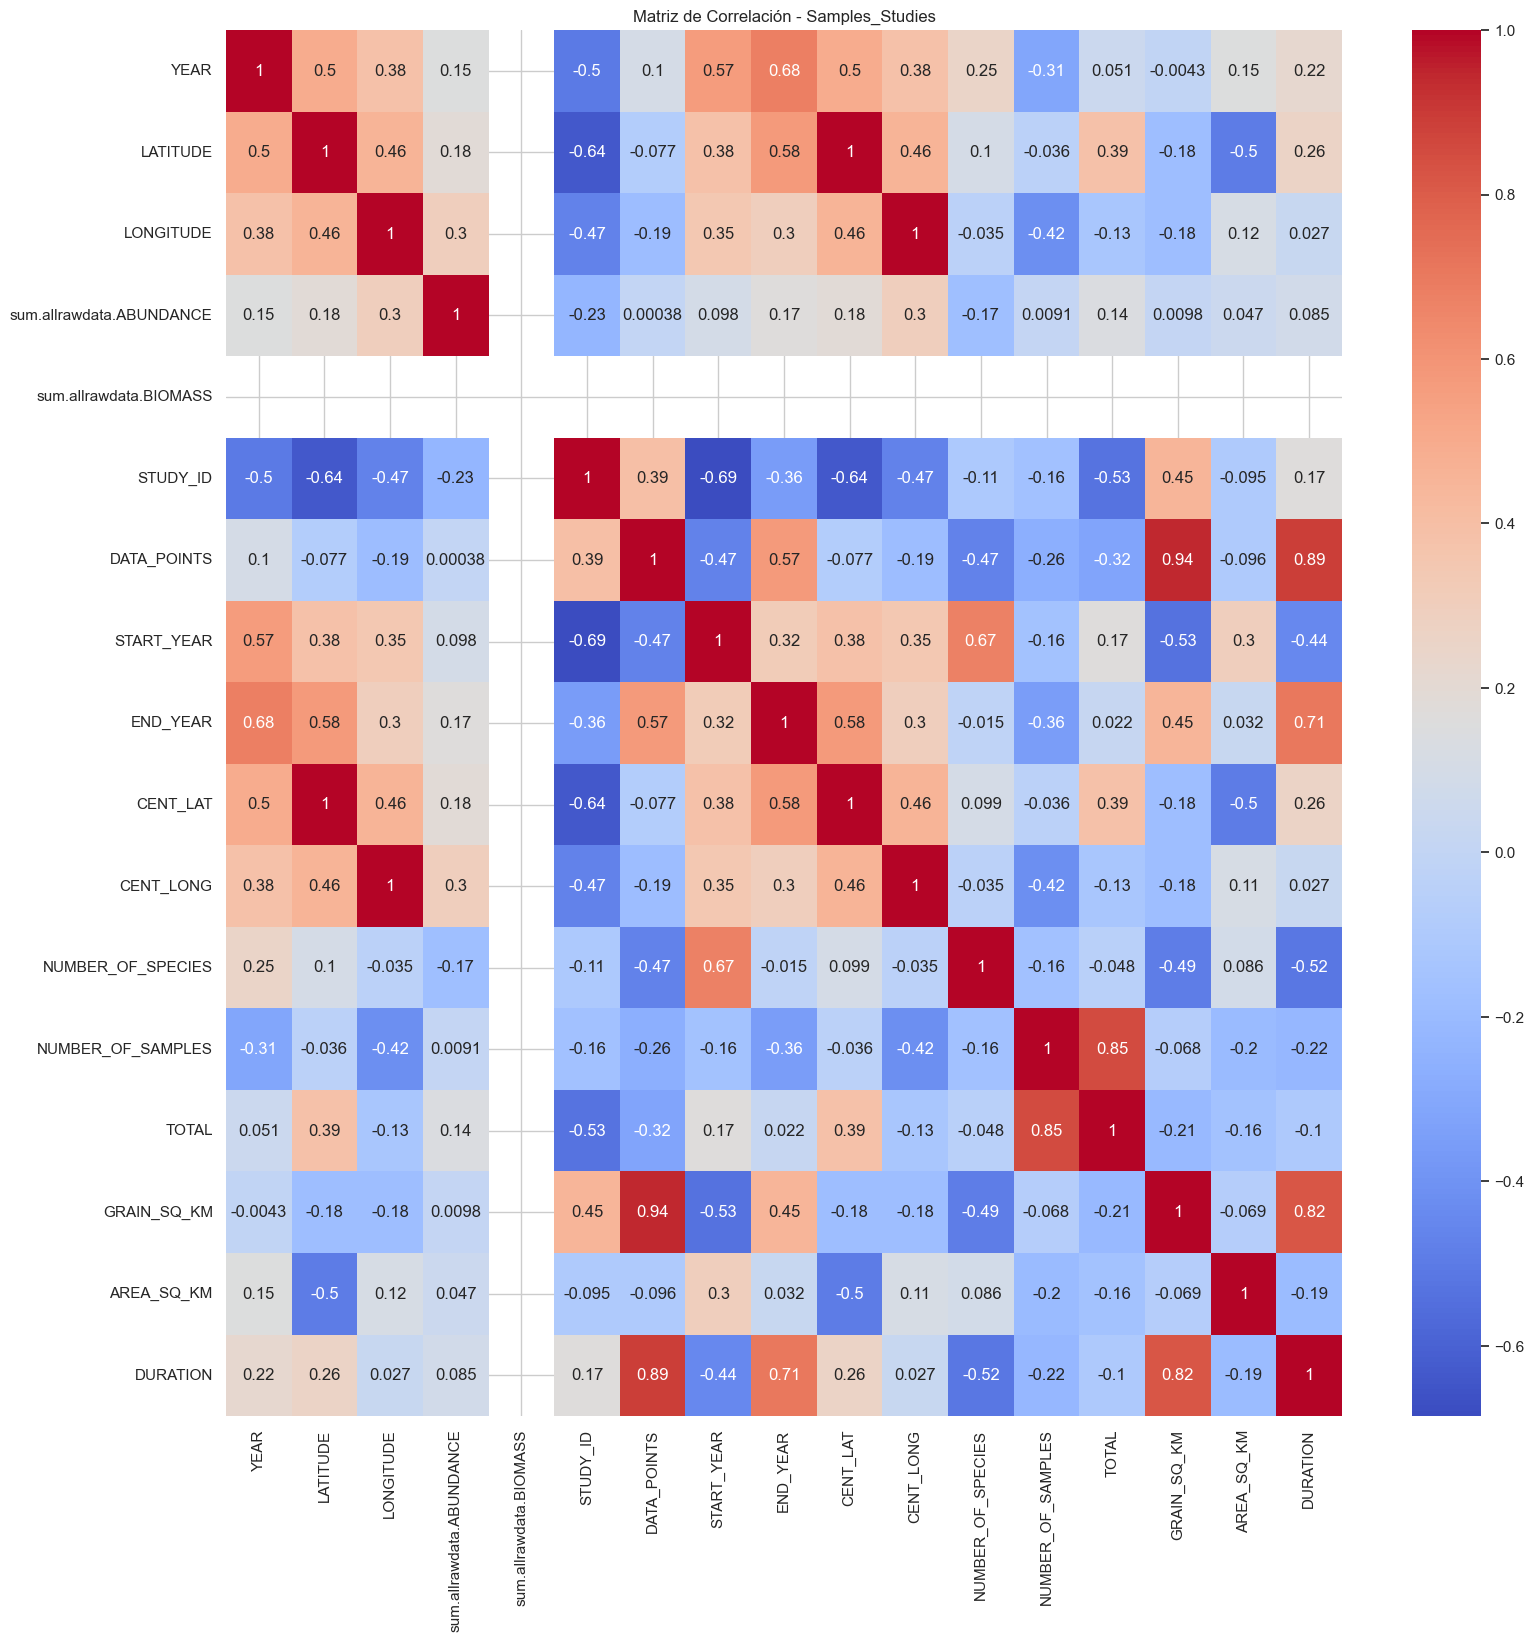

In [110]:
# Matriz de correlación para variables numéricas
corr1 = df_merged.corr()
plt.figure(figsize=(18, 18))
sns.heatmap(corr1, annot=True, cmap="coolwarm")
plt.title("Matriz de Correlación - Samples_Studies")
plt.show()

In [108]:
corr1[(corr1>0.2)&(corr1<1)]


,YEAR,LATITUDE,LONGITUDE,sum.allrawdata.ABUNDANCE,sum.allrawdata.BIOMASS,STUDY_ID,DATA_POINTS,START_YEAR,END_YEAR,CENT_LAT,CENT_LONG,NUMBER_OF_SPECIES,NUMBER_OF_SAMPLES,TOTAL,GRAIN_SQ_KM,AREA_SQ_KM
YEAR,NaN,0.497848,0.383473,NaN,NaN,NaN,NaN,0.570364,0.681372,0.497485,0.383428,0.252780,NaN,NaN,NaN,NaN
LATITUDE,0.497848,NaN,0.455368,NaN,NaN,NaN,NaN,0.382457,0.577433,0.999998,0.455535,NaN,NaN,0.387387,NaN,NaN
LONGITUDE,0.383473,0.455368,NaN,0.298038,NaN,NaN,NaN,0.346535,0.301261,0.455061,1.000000,NaN,NaN,NaN,NaN,NaN
sum.allrawdata.ABUNDANCE,NaN,NaN,0.298038,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.298036,NaN,NaN,NaN,NaN,NaN
sum.allrawdata.BIOMASS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
STUDY_ID,NaN,NaN,NaN,NaN,NaN,NaN,0.394516,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.451730,NaN
DATA_POINTS,NaN,NaN,NaN,NaN,NaN,0.394516,NaN,NaN,0.573118,NaN,NaN,NaN,NaN,NaN,0.942832,NaN
START_YEAR,0.570364,0.382457,0.346535,NaN,NaN,NaN,NaN,NaN,0.319174,0.382029,0.346444,0.674839,NaN,NaN,NaN,0.299902
END_YEAR,0.681372,0.577433,0.301261,NaN,NaN,NaN,0.573118,0.319174,NaN,0.577133,0.301245,NaN,NaN,NaN,0.447922,NaN
CENT_LAT,0.497485,0.999998,0.455061,NaN,NaN,NaN,NaN,0.382029,0.577133,NaN,0.455229,NaN,NaN,0.387359,NaN,NaN


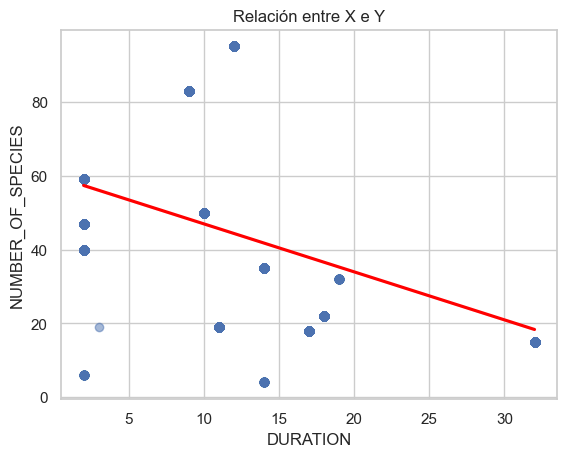

In [ ]:
# Gráfico de dispersión entre las dos variables
sns.regplot(x=df_merged["DURATION"], y=df_merged["NUMBER_OF_SPECIES"], scatter_kws={"alpha": 0.5}, line_kws={"color": "red"})
plt.title("Relación entre X e Y")
plt.show()


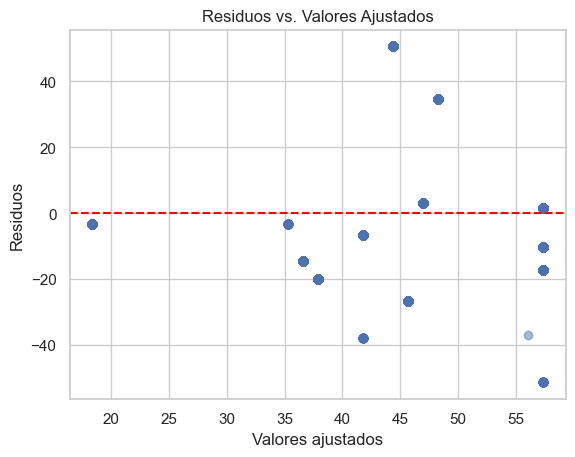

In [113]:
import statsmodels.api as sm
X = sm.add_constant(df_merged["DURATION"])  # Agrega una constante (intercepto)
y = df_merged["NUMBER_OF_SPECIES"]
modelo = sm.OLS(y, X).fit()

# Gráfico de residuos vs. valores ajustados
plt.scatter(modelo.fittedvalues, modelo.resid, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Valores ajustados")
plt.ylabel("Residuos")
plt.title("Residuos vs. Valores Ajustados")
plt.show()

In [119]:
print(len(df_merged["DURATION"]))

18744
